In [59]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Drugi zadatak
<hr>

### Testiranje hipoteza

<p>Zadatak rešavamo na sledeći način - posmatrajmo piksele slike kao trodimenzionalne slučajne vektore sa matematičkim očekivanjem $M_x$ i kovarijacionom matricom $\Sigma_x$.</p>
<p> Za segmentaciju ćemo koristiti <b>test jedne hipoteze</b> i računaćemo statističko rastojanje dato sledećom formulom, poznato i kao Mahalanobis rastojanje: </p> 

\begin{equation}
d^2(X) =  (X - M_x) ^T \Sigma_x ^{-1} (X - M_x)
\end{equation}

<p>Pravilo odlučivanja testa jedne hipoteze onda glasi:</p>
\begin{equation}
d^2(X) < t \Rightarrow X \in \omega_1
\end{equation}

\begin{equation}
d^2(X) > t \Rightarrow X \in \Omega  \setminus  \omega_1
\end{equation}

<p>Gde je $t$ prag odlučivanja, $X \in \omega_1$ odluka da je $X$ u željenoj klasi, a $X \in \Omega  \setminus  \omega_1$ odluka da nije. </p>

In [60]:
from timeit import default_timer as timer

import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from matplotlib.patches import Rectangle
import cv2
import ipywidgets as widgets
from IPython.display import display, HTML

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Učitavanje

<p>Slike su učitane u RGB formatu. Nije bilo potrebe za promenom kolor sistema jer su rezultati bili zadovoljavajući u RGB sistemu.<br> </p>


In [61]:
marilyn = np.array(image.imread('sekvence/marlyn.jpg'))
umbrella = np.array(image.imread('sekvence/street.jpg'))

### Marilyn

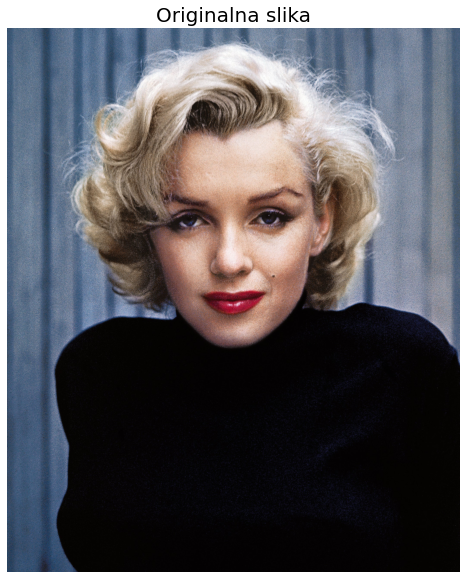

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(marilyn)
plt.title("Originalna slika", fontsize=20)
plt.axis('off')
plt.show()

In [63]:
closeup_rows = [1050, 1500]
closeup_columns = [700, 1250]

marilyn_close = np.array(marilyn[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])

datapoints_rows = [1230, 1320]
datapoints_columns = [970, 1070]

# sample - za segmentaciju ce nam biti potreban uzorak objekta koji zelimo da segmentisemo
marilyn_sample = np.array(marilyn[datapoints_rows[0]:datapoints_rows[1], datapoints_columns[0]:datapoints_columns[1], :])

#### Filtriranje
<br>
Filtriramo sliku od šuma za koji bih rekao da je impulsni pa koristimo median filtar i gledamo da sto više zamutimo detalje kao što je odsjaj usana kako bi usne ostale kao najdominantniji oblik. Filtriramo i uzorak ali sa manjom veličinom prozora filtra jer je i slika manja.

In [64]:
filter_name = 'median'

if filter_name == 'median':
    
    filt_size = 31

    filtered_closeup = cv2.medianBlur(marilyn_close, filt_size)
    filtered_img = cv2.medianBlur(marilyn, filt_size)
    
elif filter_name == 'bilateral':
    
    filt_size = 41
    sigma_s = filt_size/3
    sigma_r = 350
    filtered_closeup = cv2.bilateralFilter(marilyn_close, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s) 
    filtered_img = cv2.bilateralFilter(marilyn, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s) 
    


# ovde uzimamo median jer zelimo da ih smutimo vise ali uzimamo filtsize manji jer je slika manja
filt_size = 5
filtered_sample = cv2.medianBlur(marilyn_sample, filt_size)

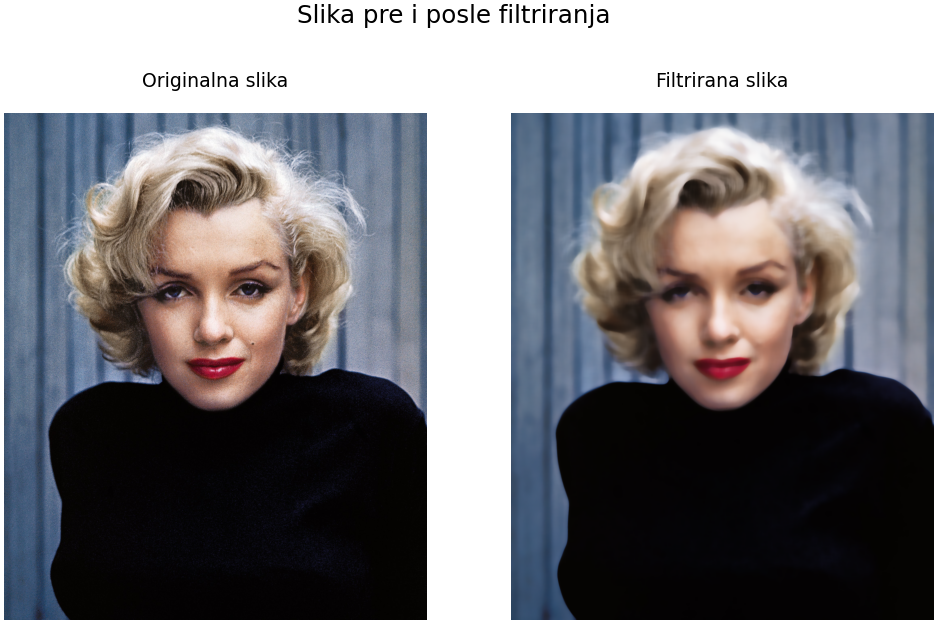

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(30,19), dpi=40);

fontsize = 34
suptitle_scale = 1.3

ax[0].imshow(marilyn)
ax[0].set_title("Originalna slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img)
ax[1].set_title("Filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Slika pre i posle filtriranja", fontsize= suptitle_scale * fontsize)
plt.show()

#### Poređenje

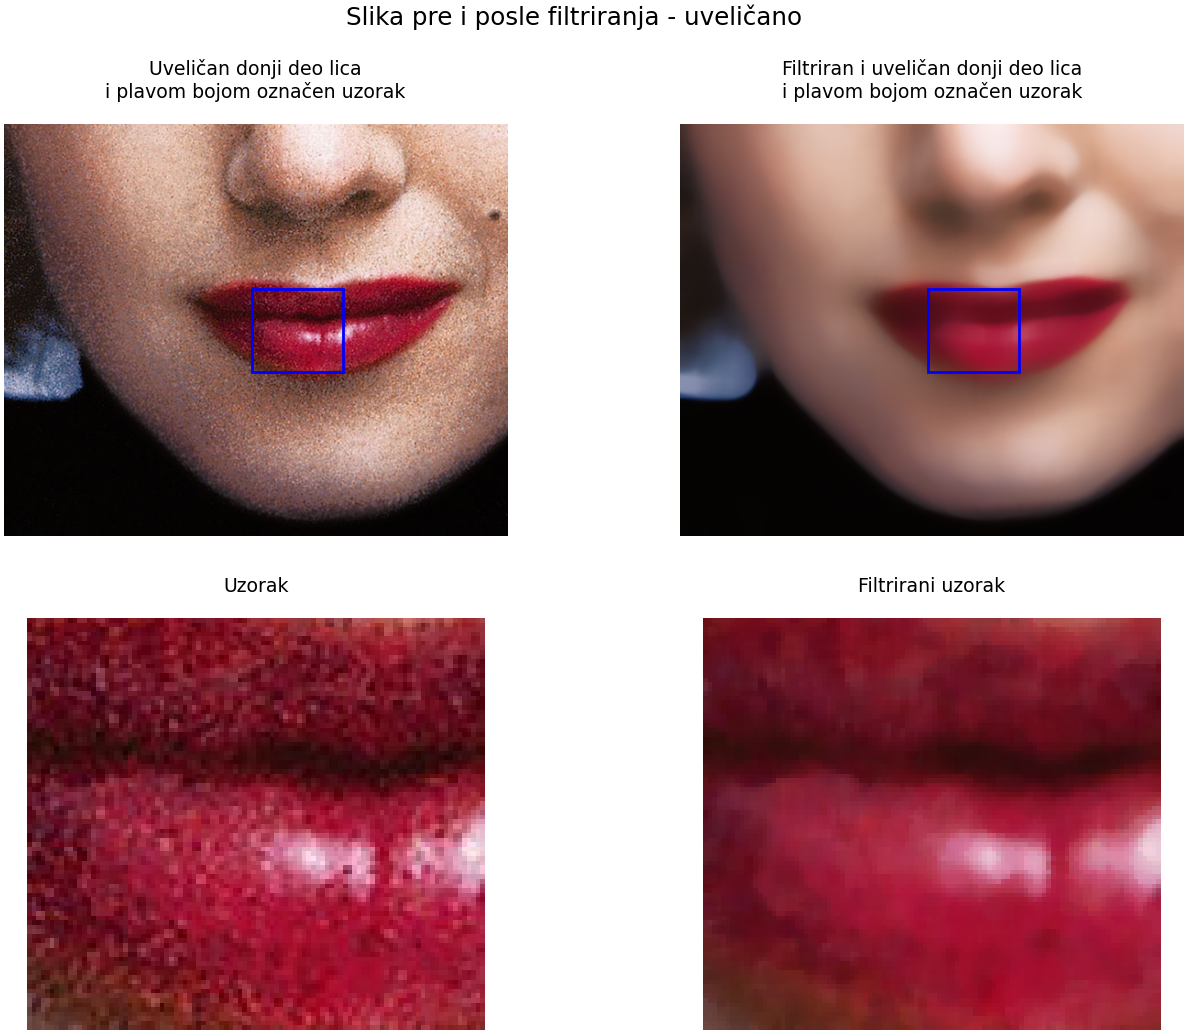

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(40,30), dpi=40);

# Nefiltrirano
# zumirano
ax[0, 0].imshow(marilyn_close)
ax[0, 0].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 0].set_title("Uveličan donji deo lica\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 0].axis('off')

# sample
ax[1, 0].imshow(marilyn_sample)
ax[1, 0].set_title("Uzorak\n", fontsize=fontsize)
ax[1, 0].axis('off')

# Filtrirano
# zumirano
ax[0, 1].imshow(filtered_closeup)
ax[0, 1].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 1].set_title("Filtriran i uveličan donji deo lica\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 1].axis('off')

# sample
ax[1, 1].imshow(filtered_sample)
ax[1, 1].set_title("Filtrirani uzorak\n", fontsize=fontsize)
ax[1, 1].axis('off')

fig.suptitle("Slika pre i posle filtriranja - uveličano", fontsize= suptitle_scale * fontsize)
plt.show()

#### Statistički parametri uzorka

In [67]:
X = filtered_sample.reshape((filtered_sample.shape[0] * filtered_sample.shape[1], 3)).T

sigma = np.cov(X)
M = np.mean(X, 1)
sigma_inv = np.linalg.inv(sigma)

# Prag odlučivanja
threshold = 5.5


#### Matrica statističkih rastojanja
<br>
<p>Za svaki piksel odredimo statističko odstojanje od uzorka i na osnovu njega kasnije donosimo odluku.</p>

In [68]:
def distance_einsum(Y, sigma_inv, M):
    Z = Y - M
    W = np.einsum("ijk,kl->ijl", Z, sigma_inv)
    d = np.einsum("ijk,ijk->ij", W, Z)
    return d

start = timer()
dist = distance_einsum(filtered_img, sigma_inv, M)
end = timer()
print("%.3f" % (end - start), " sec Vreme računanja rastojanja")

0.271  sec Vreme računanja rastojanja


#### Ilustracija metode
<br>
Delovi slike koji su tamniji imaju veće statističko rastojanje i verovatnije su deo traženog segmenta.

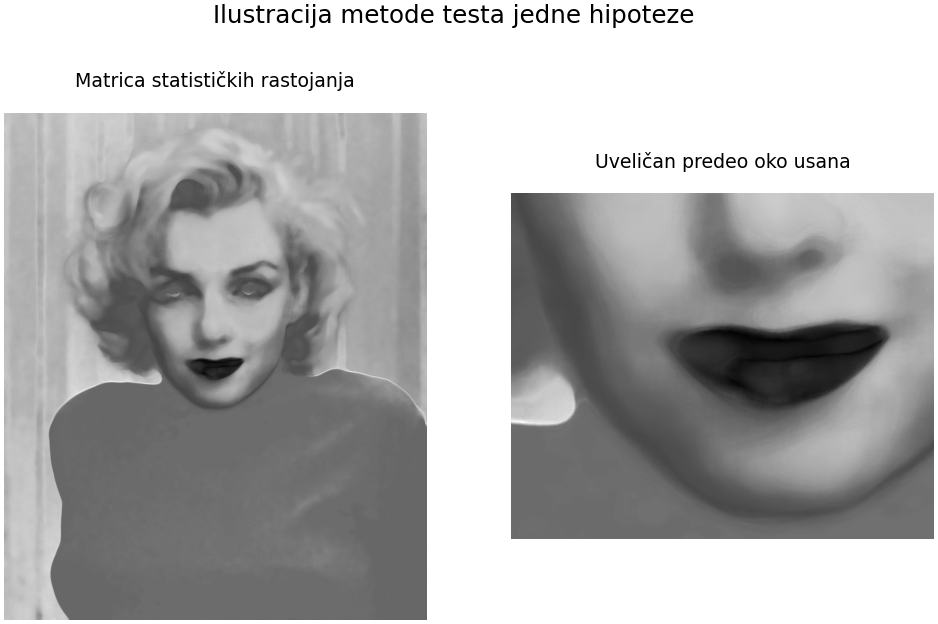

In [69]:
dist_img = dist / np.amax(dist)

# gama korekcija čisto da se bolje vidi
gamma = 2.4
dist_img = dist_img ** (1 / gamma)

fig, ax = plt.subplots(1, 2, figsize=(30,19), dpi=40);

ax[0].imshow(dist_img, cmap="gray")
ax[0].set_title("Matrica statističkih rastojanja\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(dist_img[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1]], cmap="gray")
ax[1].set_title("Uveličan predeo oko usana\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Ilustracija metode testa jedne hipoteze", fontsize= suptitle_scale * fontsize)
plt.show()

In [70]:
def gray_copy(original):
    gray = rgb2gray(original)
    gray = gray * 255
    gray = gray.astype(int)
    return gray

#### Segmentacija

In [71]:
filtered_img_segmented = np.array(filtered_img)
unfiltered_img_segmented = np.array(marilyn)

start = timer()

gray_filtered_3_channels = np.tile(gray_copy(filtered_img)[dist > threshold], (3, 1)).T

filtered_img_segmented[dist > threshold] = gray_filtered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na filtriranu sliku")

start = timer()

gray_unfiltered_3_channels = np.tile(gray_copy(unfiltered_img_segmented)[dist > threshold], (3, 1)).T
unfiltered_img_segmented[dist > threshold] = gray_unfiltered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na nefiltriranu sliku")

0.262  sec Vreme primene maske na filtriranu sliku
0.253  sec Vreme primene maske na nefiltriranu sliku


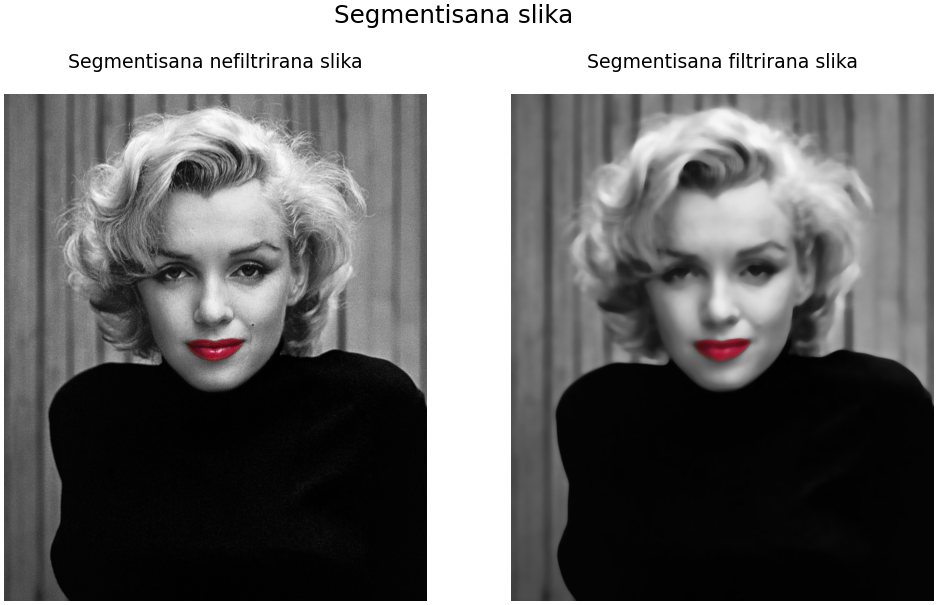

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(30,18), dpi=40);


ax[0].imshow(unfiltered_img_segmented)
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented)
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

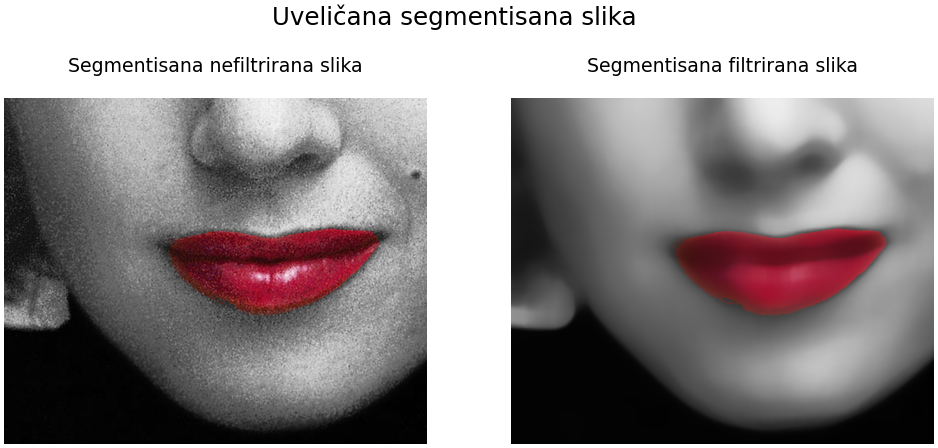

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(30,14), dpi=40);

ax[0].imshow(unfiltered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Uveličana segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

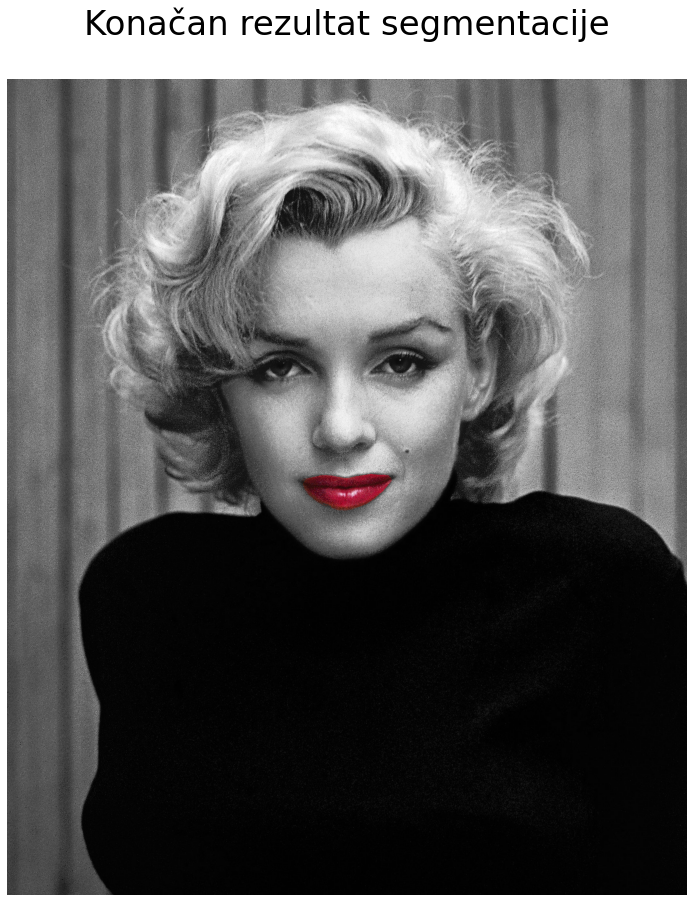

In [74]:
plt.figure(figsize=(15,15))
plt.imshow(unfiltered_img_segmented)
plt.title("Konačan rezultat segmentacije\n", fontsize=fontsize)
plt.axis('off')
plt.show()

### Kišobran

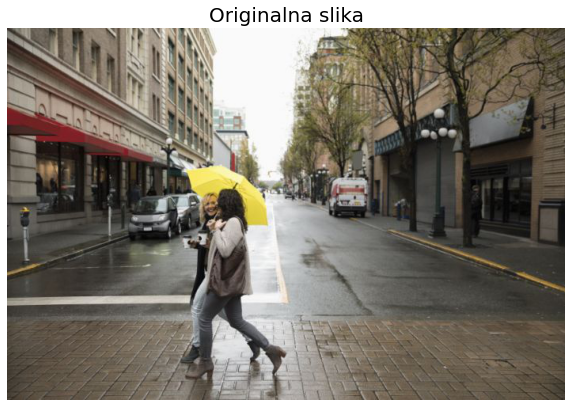

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(umbrella)
plt.title("Originalna slika", fontsize=20)
plt.axis('off')
plt.show()

In [76]:
closeup_rows = [170, 260]
closeup_columns = [210, 335]

umbrella_close = np.array(umbrella[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])

datapoints_rows = [180, 200]
datapoints_columns = [250, 280]

# sample - za segmentaciju ce nam biti potreban uzorak objekta koji zelimo da segmentisemo
umbrella_sample = np.array(umbrella[datapoints_rows[0]:datapoints_rows[1], datapoints_columns[0]:datapoints_columns[1], :])

#### Filtriranje
Za ovu sliku iskorišćen je bilateralni filtar zbog potrebe da se očuvaju ivice kišobrana.

In [77]:
filter_name = 'bilateral'

if filter_name == 'median':
    
    filt_size = 19

    filtered_closeup = cv2.medianBlur(umbrella_close, filt_size)
    filtered_img = cv2.medianBlur(umbrella, filt_size)
    
elif filter_name == 'bilateral':
    
    filt_size = 21
    sigma_s = 5
    sigma_r = 90
    filtered_closeup = cv2.bilateralFilter(umbrella_close, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s)
    umbrella_double = umbrella.astype(np.double) / 255.0
    filtered_img = cv2.bilateralFilter(umbrella, d=filt_size, sigmaColor=sigma_r, sigmaSpace=sigma_s) 
    


# ovde uzimamo median jer zelimo da ih smutimo vise ali uzimamo filtsize manji jer je slika manja
filt_size = 5
filtered_sample = cv2.medianBlur(umbrella_sample, filt_size)

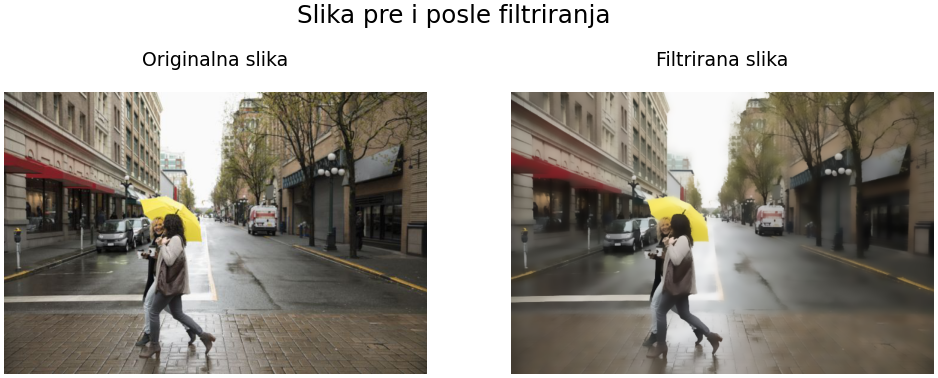

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(30,12), dpi=40);

fontsize = 34
suptitle_scale = 1.3

ax[0].imshow(umbrella)
ax[0].set_title("Originalna slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img)
ax[1].set_title("Filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Slika pre i posle filtriranja", fontsize= suptitle_scale * fontsize)
plt.show()

#### Poređenje

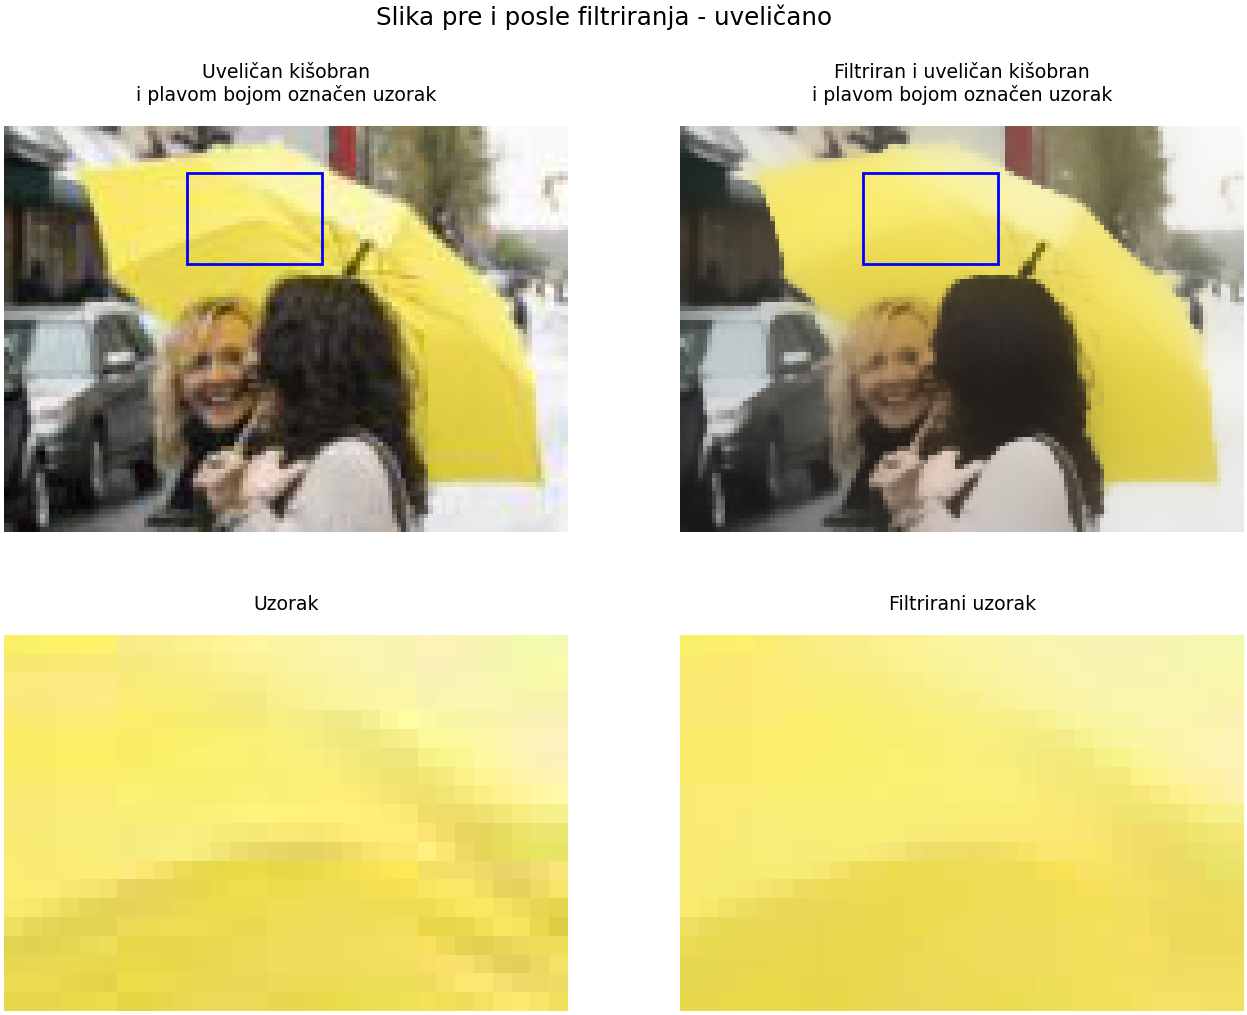

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(40,30), dpi=40);

# Nefiltrirano
# zumirano
ax[0, 0].imshow(umbrella_close)
ax[0, 0].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 0].set_title("Uveličan kišobran\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 0].axis('off')

# sample
ax[1, 0].imshow(umbrella_sample)
ax[1, 0].set_title("Uzorak\n", fontsize=fontsize)
ax[1, 0].axis('off')

# Filtrirano
# zumirano
ax[0, 1].imshow(filtered_closeup)
ax[0, 1].add_patch(Rectangle((datapoints_columns[0] - closeup_columns[0],datapoints_rows[0] - closeup_rows[0]),
                              datapoints_columns[1] - datapoints_columns[0],
                              datapoints_rows[1] - datapoints_rows[0],
                              linewidth=5,edgecolor='b',facecolor='none'))
ax[0, 1].set_title("Filtriran i uveličan kišobran\ni plavom bojom označen uzorak\n", fontsize=fontsize)
ax[0, 1].axis('off')

# sample
ax[1, 1].imshow(filtered_sample)
ax[1, 1].set_title("Filtrirani uzorak\n", fontsize=fontsize)
ax[1, 1].axis('off')

fig.suptitle("Slika pre i posle filtriranja - uveličano", fontsize= suptitle_scale * fontsize)
plt.show()

#### Statistički parametri uzorka

In [80]:
X = filtered_sample.reshape((filtered_sample.shape[0] * filtered_sample.shape[1], 3)).T

sigma = np.cov(X)
M = np.mean(X, 1)
sigma_inv = np.linalg.inv(sigma)

# Prag odlučivanja
threshold = 60

#### Matrica statističkih rastojanja

In [81]:
start = timer()
dist = distance_einsum(filtered_img, sigma_inv, M)
end = timer()
print("%.3f" % (end - start), " sec Vreme računanja rastojanja")

0.025  sec Vreme računanja rastojanja


#### Ilustracija metode
Delovi slike koji su tamniji imaju veće statističko rastojanje i verovatnije su deo traženog segmenta.

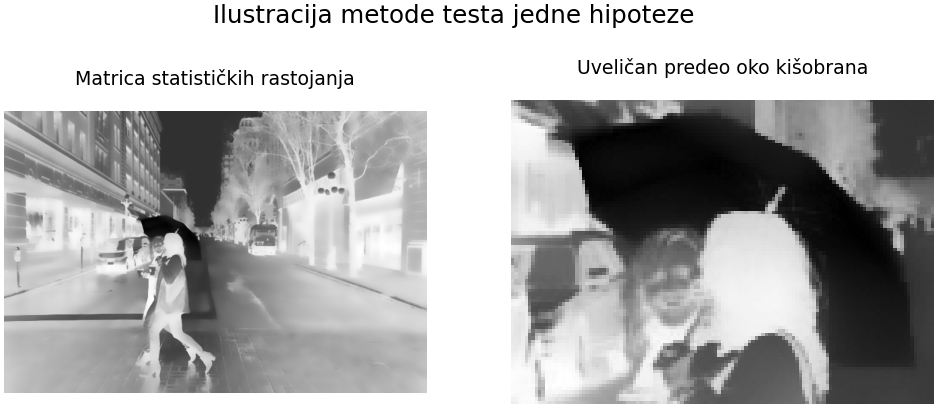

In [82]:
dist_img = dist / np.amax(dist)

# gama korekcija čisto da se bolje vidi
gamma = 2.4
dist_img = dist_img ** (1 / gamma)

fig, ax = plt.subplots(1, 2, figsize=(30,13), dpi=40);

ax[0].imshow(dist_img, cmap="gray")
ax[0].set_title("Matrica statističkih rastojanja\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(dist_img[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1]], cmap="gray")
ax[1].set_title("Uveličan predeo oko kišobrana\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Ilustracija metode testa jedne hipoteze", fontsize= suptitle_scale * fontsize)
plt.show()

#### Segmentacija

In [83]:
filtered_img_segmented = np.array(filtered_img)
unfiltered_img_segmented = np.array(umbrella)

start = timer()

gray_filtered_3_channels = np.tile(gray_copy(filtered_img)[dist > threshold], (3, 1)).T

filtered_img_segmented[dist > threshold] = gray_filtered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na filtriranu sliku")

start = timer()

gray_unfiltered_3_channels = np.tile(gray_copy(unfiltered_img_segmented)[dist > threshold], (3, 1)).T
unfiltered_img_segmented[dist > threshold] = gray_unfiltered_3_channels

end = timer()
print("%.3f" % (end - start), " sec Vreme primene maske na nefiltriranu sliku")

0.029  sec Vreme primene maske na filtriranu sliku
0.027  sec Vreme primene maske na nefiltriranu sliku


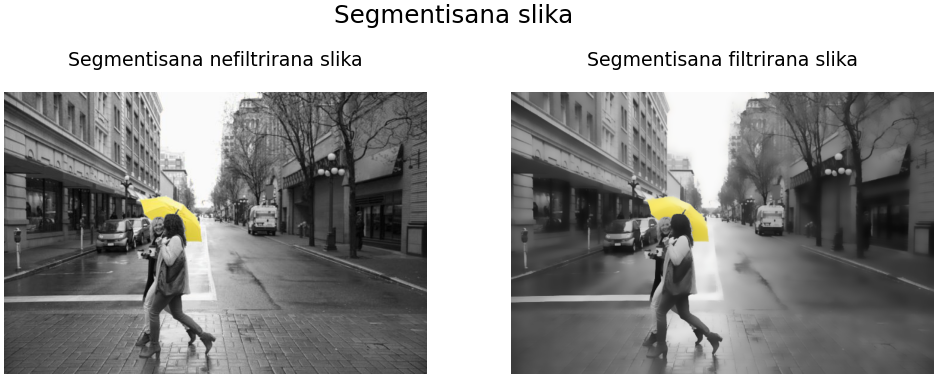

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(30,12), dpi=40);


ax[0].imshow(unfiltered_img_segmented)
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented)
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

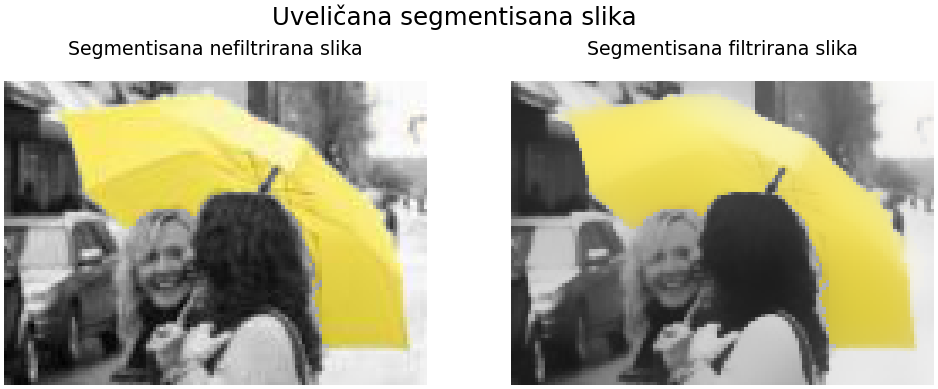

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(30,12), dpi=40);

ax[0].imshow(unfiltered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[0].set_title("Segmentisana nefiltrirana slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(filtered_img_segmented[closeup_rows[0]:closeup_rows[1], closeup_columns[0]:closeup_columns[1], :])
ax[1].set_title("Segmentisana filtrirana slika\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Uveličana segmentisana slika", fontsize= suptitle_scale * fontsize)
plt.show()

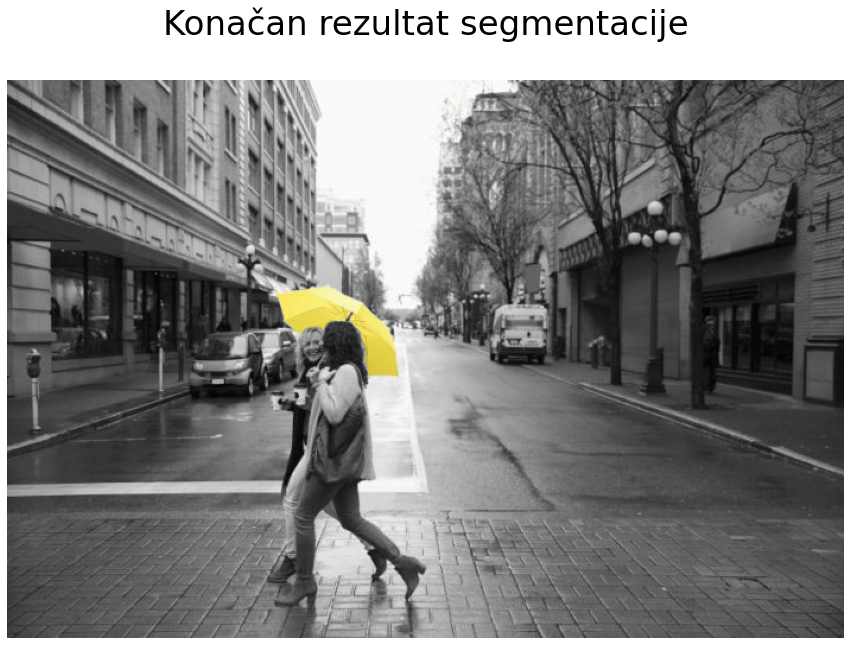

In [86]:
plt.figure(figsize=(15,15))
plt.imshow(unfiltered_img_segmented)
plt.title("Konačan rezultat segmentacije\n", fontsize=fontsize)
plt.axis('off')

plt.show()

In [87]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>